In [2]:
# Do some imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt



# Load data and process data
data_dir = "../data/"

In [3]:
def load_data(data_dir):
    train = pd.read_json(data_dir+"train.json")
    test = pd.read_json(data_dir+"test.json")
    # Fill 'na' angles with zero
    train.inc_angle = train.inc_angle.replace('na', 0)
    train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
    test.inc_angle = test.inc_angle.replace('na', 0)
    test.inc_angle = test.inc_angle.astype(float).fillna(0.0)
    return train, test

train, test = load_data(data_dir)

In [4]:
# Process data into images
def process_images(df):
    X_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_1"]])
    X_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df["band_2"]])
    # Merge bands and add another band as the mean of Band 1 and Band 2 (useful for the ImageDataGenerator later)
    imgs = np.concatenate([X_band1[:, :, :, np.newaxis]
                            , X_band2[:, :, :, np.newaxis]
                            ,((X_band1+X_band2)/2)[:, :, :, np.newaxis]], axis=-1)
    return imgs

X_train = process_images(train)
X_test = process_images(test)

X_angle_train = np.array(train.inc_angle)
X_angle_test = np.array(test.inc_angle)
y_train = np.array(train["is_iceberg"])

In [5]:
X_train.shape

(1604, 75, 75, 3)

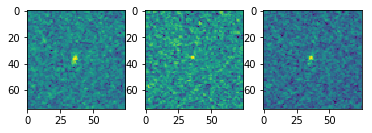

1


In [6]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(X_train[2,:,:,0])
ax[1].imshow(X_train[2,:,:,1])
ax[2].imshow(X_train[2,:,:,2])
plt.show()
print(y_train[2])

The MatLab code for doing the EMD can be run from python by starting a MatLab-engine instance

In [7]:
import matlab.engine

In [33]:
#epsilon = 0.1
#conn = '8m'
numberimfs = 4
eng = matlab.engine.start_matlab()

In [9]:
# Calculate IMFs, residue, and medel(?) using matlab wrapper
def IEMD(img, epsilon=0.1, numberimfs=4, conn='8m'):
    matlab_arr = matlab.double(img.tolist())
    matlab_imfs, matlab_residue, matlab_medel = eng.IEMD_public(matlab_arr, epsilon, numberimfs, conn, nargout=3) 
    
    imfs = np.asarray(matlab_imfs)
    residue = np.asarray(matlab_residue)
    medel = np.asarray(matlab_medel)
    return imfs, residue, medel

In [20]:
def plot_IEMD(img, imfs):
    fig, ax = plt.subplots(2,1 + np.shape(imfs)[2], figsize=(20, 12))
    fig.tight_layout(h_pad=3)
    fig.subplots_adjust(hspace=0.1)

    ax[0][0].imshow(img)
    ax[0][0].set_title("Original image")
    ax[1][0].imshow(img)
    ax[1][0].set_title("Original image")

    filtered_img_sub = np.copy(img)
    filtered_img_add = np.copy(img)
    for imf in range(np.shape(imfs)[2]):
        ax[0][imf + 1].imshow(imfs[:,:,imf])
        ax[0][imf + 1].set_title("IMF" + str(imf + 1))

        filtered_img_sub = filtered_img_sub - imfs[:,:,imf]
        ax[1][imf + 1].imshow(filtered_img_sub)
        ax[1][imf + 1].set_title(str(imf + 1) + " IMF(s) subtracted")


    plt.show()

In [22]:
def print_label(idx):
    if y_train[idx]:
        print("Iceberg")
    else:
        print("Ship")

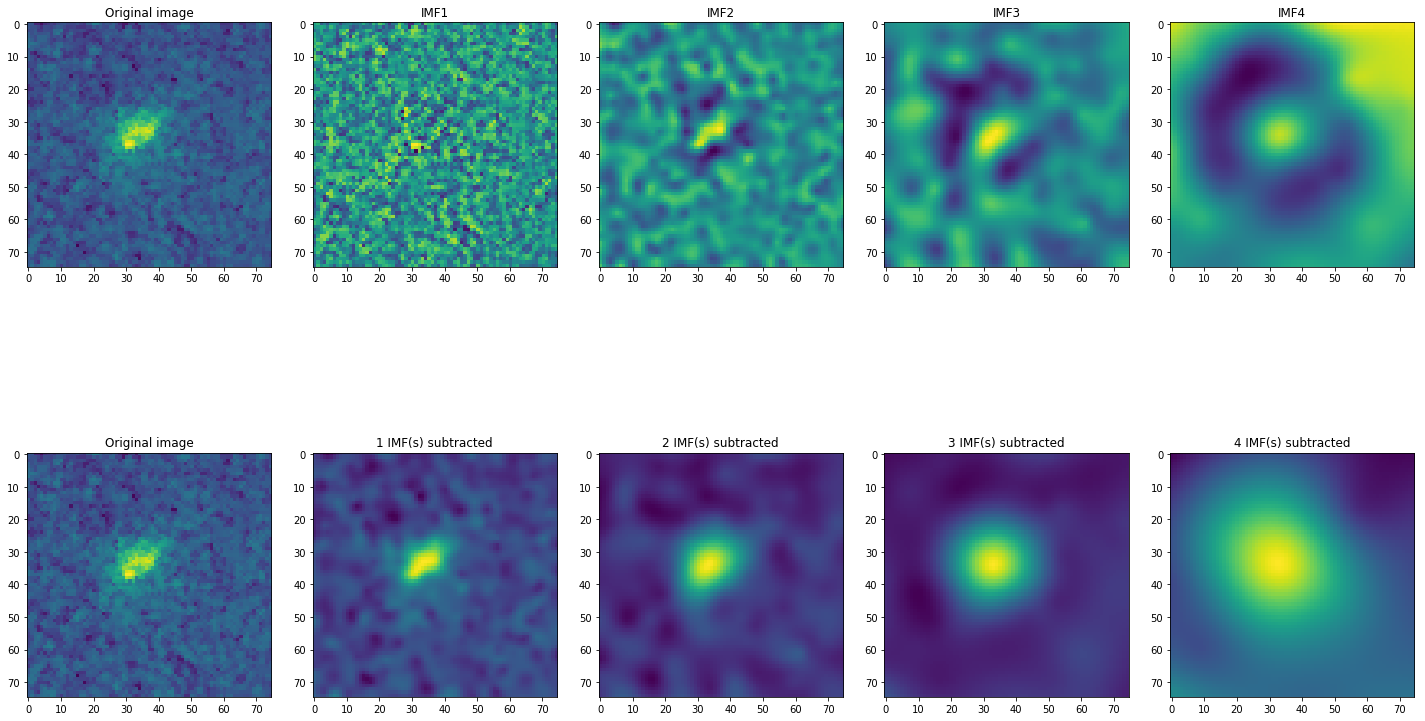

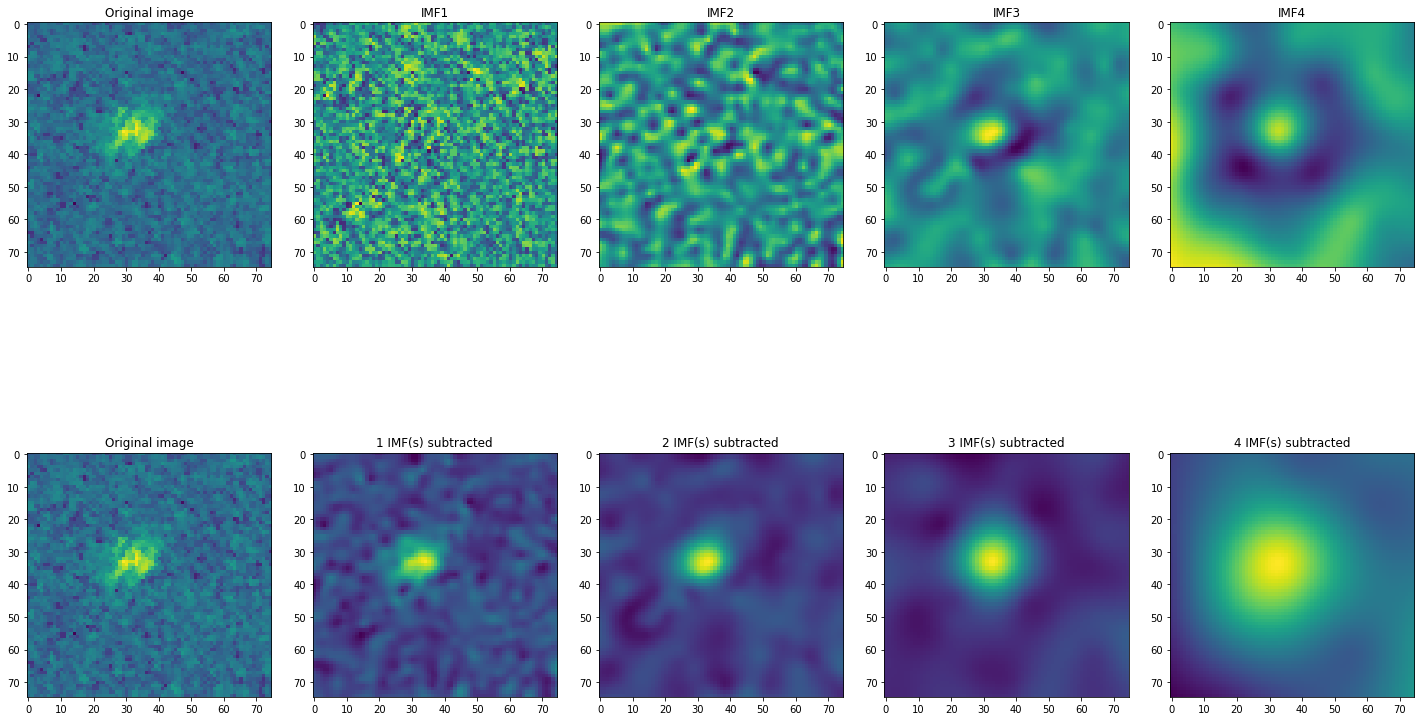

Iceberg


In [101]:
idx = 5

img_band1 = X_train[idx,:,:,0]
imfs, residue, medel = IEMD(img_band1)
plot_IEMD(img_band1, imfs)

img_band2 = X_train[idx,:,:,1]
imfs, residue, medel = IEMD(img_band2)
plot_IEMD(img_band2, imfs)

print_label(idx)

===============================================================================================

Next we build the dataset now with the IMFs included each as their own column.

In [26]:
train = pd.read_json(data_dir+"train.json")

In [27]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [68]:
# Create the columns in the pandas object for each IMF
for band in range(1,3):
    for imf in range(1,numberimfs + 1):
        column_name = "band_" + str(band) + "_imf_" + str(imf)
        #train[column_name] = np.nan
        train[column_name] = np.empty((len(train), 0)).tolist()
        #train[column_name] = np.zeros((75,75)).reshape(1, 75 * 75).tolist()
train.head()

,band_1,band_2,id,inc_angle,is_iceberg,band_1_imf_1,band_1_imf_2,band_1_imf_3,band_1_imf_4,band_2_imf_1,band_2_imf_2,band_2_imf_3,band_2_imf_4
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0,[],[],[],[],[],[],[],[]
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0,[],[],[],[],[],[],[],[]
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1,[],[],[],[],[],[],[],[]
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0,[],[],[],[],[],[],[],[]
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0,[],[],[],[],[],[],[],[]


In [73]:
# Calculate every IMF for every image
from timeit import default_timer as timer
num_img = len(X_train)
start_time = timer()
for i, images in enumerate(X_train):
    band1_imf, _, _ = IEMD(images[:,:,0])
    band2_imf, _, _ = IEMD(images[:,:,1])
    
    for imf in range(numberimfs):
        column_name_band1 = "band_1_imf_" + str(imf + 1)
        column_name_band2 = "band_2_imf_" + str(imf + 1)
        train.set_value(i, column_name_band1, band1_imf[:,:,imf].reshape(75 * 75).tolist())
        train.set_value(i, column_name_band2, band2_imf[:,:,imf].reshape(75 * 75).tolist())
    
    msg = "Image " + str(i) + "/" + str(num_img) + " completed..."
    print (msg, end="\r")
    if i == 10:
        break
print("Total run time: " + str(timer() - start_time))

Total run time: 30.779437899000186


================================================================================================================

Then we validate that it's correct

In [78]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg,band_1_imf_1,band_1_imf_2,band_1_imf_3,band_1_imf_4,band_2_imf_1,band_2_imf_2,band_2_imf_3,band_2_imf_4
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0,"[-1.0988919318538137, 1.2394438759956756, 1.40...","[1.1319092476878723, -0.3276233547447873, -1.8...","[-0.794302317901618, -0.8981179435983222, -1.0...","[-0.11552031905409788, -0.144208450196448, -0....","[4.605481934633644, 1.8531034167335747, -0.445...","[-1.391348204680753, -0.6644049759709105, 0.49...","[-1.1130209481088222, -1.4270182308546921, -1....","[1.2058021647787474, 1.171156506013092, 1.1340..."
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0,"[2.427835734653854, -1.378095010622019, -2.338...","[-2.825449222801808, -1.581870904849012, -0.49...","[0.777312735470312, 0.6550471867318157, 0.5287...","[-0.7911746285929953, -0.7220820441079043, -0....","[-2.6411338709499432, -0.6127070688917229, -0....","[-1.7494047701179056, -0.5878815035860896, 0.4...","[-0.7410424110050293, -0.5397889650911498, -0....","[-1.014016176286356, -0.8394511398386912, -0.6..."
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1,"[-2.3517035974427927, -2.510544989952905, -2.9...","[-0.07528019462830571, 0.044060073841933445, 0...","[0.01941453307530594, 0.03363684017909563, 0.0...","[-0.10098725977174894, -0.04115599631823841, 0...","[-2.9455213595240366, -1.7547973946705042, 1.9...","[1.8597998744434676, 1.580819665981437, 1.4414...","[1.0314600417035429, 0.907646675490458, 0.7921...","[0.3392259250831917, 0.3342704539634953, 0.328..."
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0,"[0.37455575552303344, -0.022349550135686513, -...","[0.6327495403672572, 0.5769199350554572, 0.688...","[0.5233987448300823, 0.3934941993193206, 0.232...","[-0.4771500609343824, -0.41832076020040976, -0...","[0.29306963239014294, 0.9433731331296258, 1.45...","[0.24612225133319043, -0.1824086219775154, -0....","[0.7694352307072734, 0.9417714355541058, 1.076...","[-0.154049417685319, -0.17252684608729252, -0...."
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0,"[-1.8041258832254243, 1.1693541807144356, 1.06...","[-0.9845684787081268, -0.6014125404179822, 0.1...","[1.8111922428873548, 1.3180412665660342, 0.721...","[0.28868938036303327, 0.2583014430011703, 0.21...","[-2.4759657869869898, -4.873336574781206, -4.3...","[0.553135430171551, -0.0596395318044074, -0.52...","[1.576018749911782, 1.5508947952609518, 1.4858...","[-0.416428143059961, -0.43503541833776893, -0...."


In [98]:
#Verify that IMFs fit with the correct image
def plot_IEMD_from_row(row, band):
    img = np.reshape(row["band_" + str(band)], (75,75))
    
    fig, ax = plt.subplots(2,1 + np.shape(imfs)[2], figsize=(20, 12))
    fig.tight_layout(h_pad=3)
    fig.subplots_adjust(hspace=0.1)

    ax[0][0].imshow(img)
    ax[0][0].set_title("Original image")
    ax[1][0].imshow(img)
    ax[1][0].set_title("Original image")
    
    filtered_img_sub = np.copy(img)
    for imf_idx in range(numberimfs):
        column_name = "band_" + str(band) + "_imf_" + str(imf_idx + 1)
        imf = np.reshape(row[column_name], (75,75))
        
        ax[0][imf_idx + 1].imshow(imf)
        ax[0][imf_idx + 1].set_title("IMF" + str(imf_idx + 1))
        
        filtered_img_sub = filtered_img_sub - imf
        ax[1][imf_idx + 1].imshow(filtered_img_sub)
        ax[1][imf_idx + 1].set_title(str(imf_idx + 1) + " IMF(s) subtracted")


    plt.show()

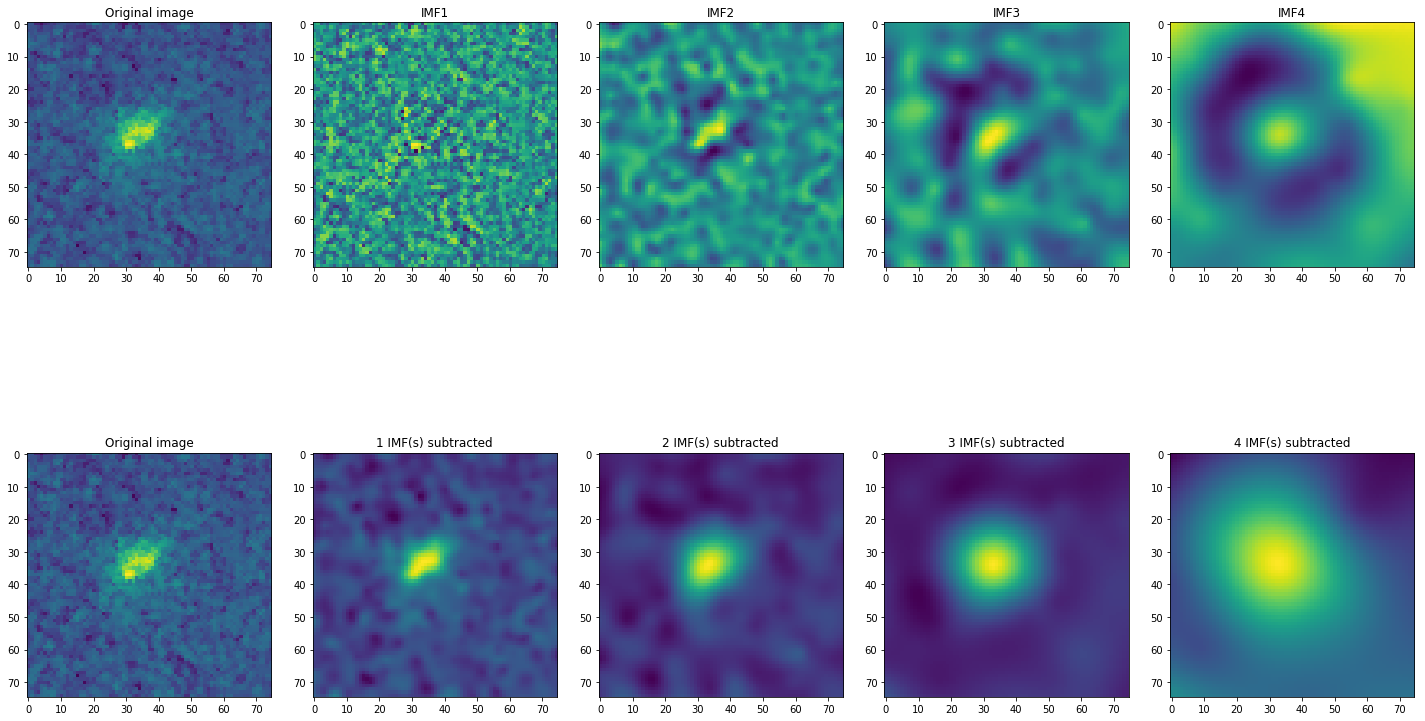

In [102]:
plot_IEMD_from_row(train.iloc[5], 1)

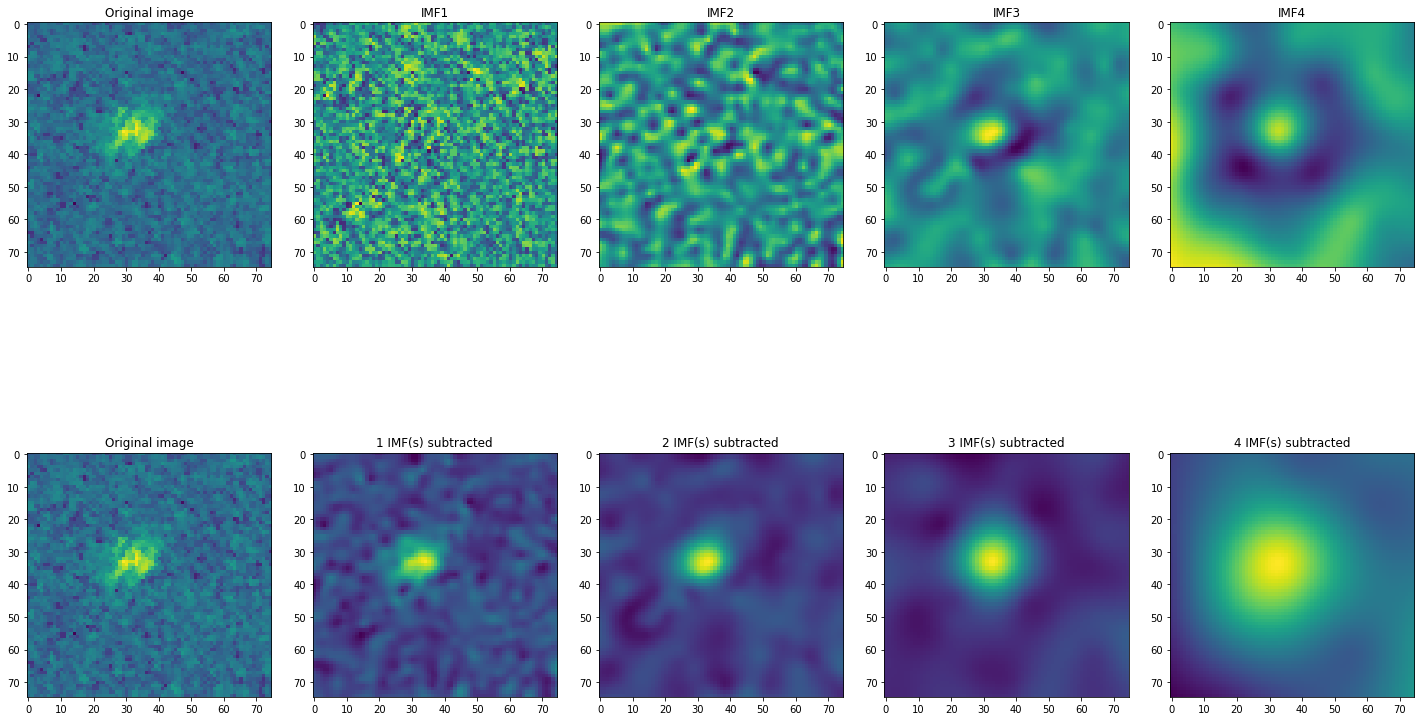

In [103]:
plot_IEMD_from_row(train.iloc[5], 2)